YoloV4 Detection Example
===

What does this notebook do?
1. Install `tf2_yolov4` with pip.
2. Download [weights](https://docs.google.com/u/0/uc?export=download&confirm=AkzU&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT) from darknet YoloV4 trained on COCO and convert them to tensorflow weights.
3. Instanciate YoloV4 model, load COCO weights and run prediction on a single image.

## 1. Install `tf2_yolov4` + TensorFlow

In [ ]:
!pip install tf2_yolov4
!pip install tensorflow==2.2.0

## 2. Get COCO pretrained weights

First, download `yolov4.weights` from [AlexeyAB/darknet](https://docs.google.com/u/0/uc?export=download&confirm=AkzU&id=1cewMfusmPjYWbrnuJRuKhPMwRe_b9PaT) repository.
The `yolov4.weights` file length should be `257717640`. If not, rerun the cell.

Move `yolov4.weights` to the path `src\weights\yolov4.weights`

`tf2_yolov4` provides a `convert-darknet-weights`, a script to convert a darknet weights file (*.weights) to a tensorflow weights file (*.h5):

In [ ]:
!convert-darknet-weights "..\weights\yolov4.weights" -o "..\weights\yolov4.h5"
!dir -la "..\weights\yolov4.h5"

## 3. Run a prediction

Import tensorflow, tf2_yolov4 model and anchors

In [1]:
import tensorflow as tf
from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
from IPython.display import Image

In [10]:
imagePath = '../../../images/gg.jpg'
weights_path = '../../../models/yolov4.h5'
HEIGHT, WIDTH = (640, 960)

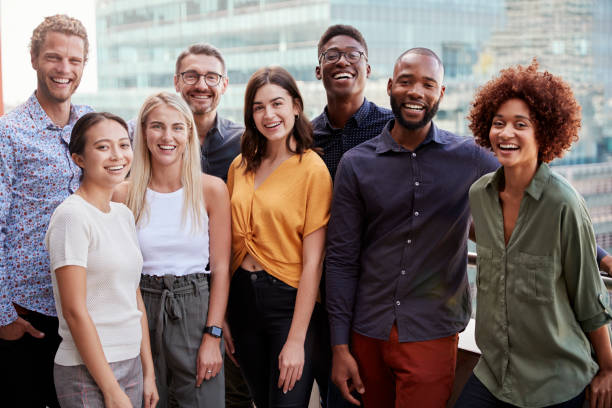

In [11]:
Image(imagePath)

Open and preprocess the image with TensorFlow:

In [12]:
image = tf.io.read_file(imagePath)
image = tf.image.decode_image(image)
image = tf.image.resize(image, (HEIGHT, WIDTH))
images = tf.expand_dims(image, axis=0) / 255.0

Create YoloV4 model and load COCO weights:

In [13]:
model = YOLOv4(
    input_shape=(HEIGHT, WIDTH, 3),
    anchors=YOLOV4_ANCHORS,
    num_classes=80,
    training=False,
    yolo_max_boxes=100,
    yolo_iou_threshold=0.5,
    yolo_score_threshold=0.5,
)

model.load_weights(weights_path)
model.summary()

Model: "YOLOv4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 640, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 CSPDarknet53 (Functional)      [(None, 20, 30, 102  26652512    ['input_16[0][0]']               
                                4),                                                               
                                 (None, 40, 60, 512                                               
                                ),                                                                
                                 (None, 80, 120, 25                                          

Predict:

In [14]:
boxes, scores, classes, valid_detections = model.predict(images)

Draw the output bounding boxes:

In [15]:
# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [52]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def plot_results(pil_img, boxes, scores, classes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax), score, cl in zip(boxes.tolist(), scores.tolist(), classes.tolist()):
        if score > 0:
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=COLORS[cl % 6], linewidth=3))
          text = f'{CLASSES[cl]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          print(text)
    plt.axis('off')
    plt.show()

person: 0.99
person: 0.97
person: 0.95
person: 0.95
person: 0.93
person: 0.90


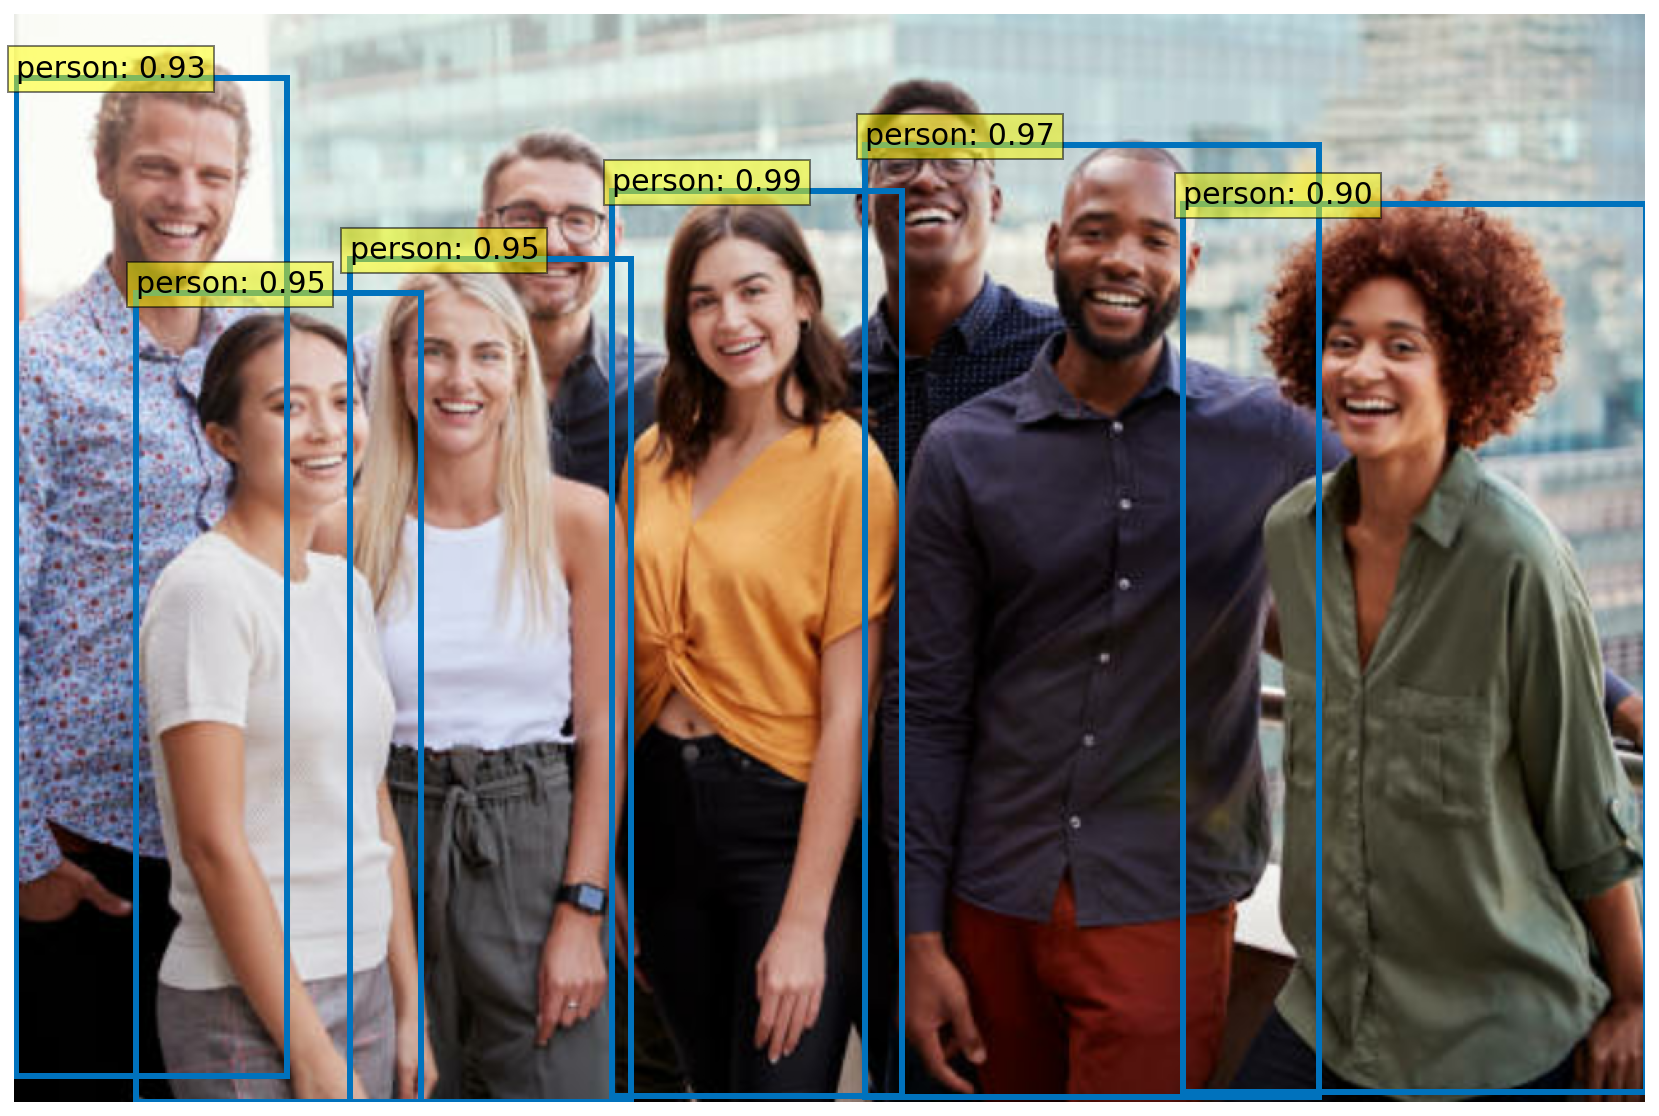

In [53]:
plot_results(
    images[0],
    boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT],
    scores[0],
    classes[0].astype(int),
)